In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

From our volatility analysis, it seems the most profitable stock is Amazon. In this part, we try and predict the open stock prices of Amazon with a simple LSTM. Since I don't know which particular architect, we choose a simple one.

In [2]:
amzn = pd.read_csv('StockData/AMZN.csv', index_col = 'Date')

We will use years 2014 to the end of 2018 as our training set, and then test our model on current months of 2019.

In [3]:
amznTrain = amzn.loc[(amzn.index>='2014-01-01') & (amzn.index<='2018-12-31')]

In [4]:
amznTrain.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-01-02,399.359985,394.019989,398.799988,397.970001,2137800,397.970001
2014-01-03,402.709991,396.220001,398.290009,396.440002,2210200,396.440002
2014-01-06,397.000000,388.420013,395.850006,393.630005,3170600,393.630005
2014-01-07,398.470001,394.290009,395.040009,398.029999,1916000,398.029999
2014-01-08,403.000000,396.040009,398.470001,401.920013,2316500,401.920013


In [5]:
#making sure there are no NA values
amznTrain.isna().any()

High         False
Low          False
Open         False
Close        False
Volume       False
Adj Close    False
dtype: bool

In [6]:
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [7]:
trainSet = amznTrain['Open']
trainSet = pd.DataFrame(trainSet)

In [8]:
sc = MinMaxScaler(feature_range = (0, 1))
scaleTSet = sc.fit_transform(trainSet)

In [9]:
len(scaleTSet)

1258

In [10]:
XTrain = []
yTrain = []
for i in range(50, 1258):
    XTrain.append(scaleTSet[i-50:i,0])
    yTrain.append(scaleTSet[i,0])
XTrain, yTrain = np.array(XTrain), np.array(yTrain)

XTrain = np.reshape(XTrain, (XTrain.shape[0], XTrain.shape[1], 1))

In [12]:
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (XTrain.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

In [25]:
#fitting the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(XTrain, yTrain, epochs = 50, batch_size = 32)

Epoch 1/50
1208/1208 [==============================] - 15s 12ms/step - loss: 0.0046
Epoch 2/50
1208/1208 [==============================] - 12s 10ms/step - loss: 0.0028
Epoch 3/50
1208/1208 [==============================] - 12s 10ms/step - loss: 0.0025
Epoch 4/50
1208/1208 [==============================] - 12s 10ms/step - loss: 0.0021
Epoch 5/50
1208/1208 [==============================] - 13s 11ms/step - loss: 0.0021
Epoch 6/50
1208/1208 [==============================] - 13s 10ms/step - loss: 0.0024
Epoch 7/50
1208/1208 [==============================] - 13s 11ms/step - loss: 0.0020
Epoch 8/50
1208/1208 [==============================] - 13s 11ms/step - loss: 0.0021
Epoch 9/50
1208/1208 [==============================] - 13s 10ms/step - loss: 0.0017
Epoch 10/50
1208/1208 [==============================] - 13s 10ms/step - loss: 0.0020
Epoch 11/50
1208/1208 [==============================] - 13s 10ms/step - loss: 0.0016
Epoch 12/50
1208/1208 [==============================] - 13s 10

In [26]:
amznTest = amzn.loc[(amzn.index>='2019-01-01')]

In [27]:
amznTest.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-01-02,1553.359985,1460.930054,1465.199951,1539.130005,7983100,1539.130005
2019-01-03,1538.000000,1497.109985,1520.010010,1500.280029,6975600,1500.280029
2019-01-04,1594.000000,1518.310059,1530.000000,1575.390015,9182600,1575.390015
2019-01-07,1634.560059,1589.189941,1602.310059,1629.510010,7993200,1629.510010
2019-01-08,1676.609985,1616.609985,1664.689941,1656.579956,8881400,1656.579956


In [28]:
realPrice = amznTest.iloc[:,1:2].values

In [29]:
testSet = amznTest['Open']
testSet = pd.DataFrame(testSet)

In [31]:
allSet = pd.concat((amznTrain['Open'], amznTest['Open']), axis = 0)
inputs = allSet[len(allSet) - len(testSet) - 50:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
XTest = []
for i in range(50, 116):
    XTest.append(inputs[i-50:i, 0])
XTest = np.array(XTest)
XTest = np.reshape(XTest, (XTest.shape[0], XTest.shape[1], 1))
predPrice = model.predict(XTest)
predPrice = sc.inverse_transform(predPrice)

In [32]:
predPrice = pd.DataFrame(predPrice)
predPrice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 1 columns):
0    66 non-null float32
dtypes: float32(1)
memory usage: 344.0 bytes


In [33]:
#predPrice

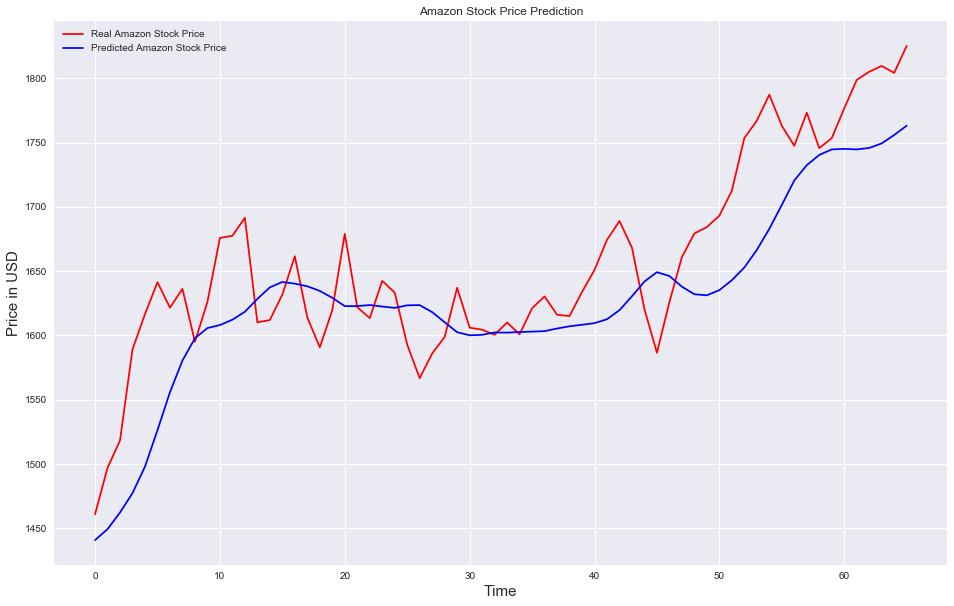

In [37]:
plt.style.use('seaborn')
plt.figure(figsize=(16, 10))
plt.plot(realPrice, color = 'red', label = 'Real Amazon Stock Price')
plt.plot(predPrice, color = 'blue', label = 'Predicted Amazon Stock Price')
plt.title('Amazon Stock Price Prediction')
plt.xlabel('Time', fontsize = 15)
plt.ylabel('Price in USD', fontsize = 15)
plt.legend()
plt.show()

Not too bad for a simple architect.